In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import re
import datetime
import missingno as msno

from sklearn.linear_model import (Ridge,
                                  Lasso,
                                  ElasticNet,
                                  LinearRegression)
from sklearn.preprocessing import (PolynomialFeatures,
                                   StandardScaler)
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV)
from sklearn.cluster import DBSCAN

from sklearn.metrics import mean_absolute_percentage_error

from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

import lightgbm as lgb
import xgboost as xgb


# Data preprocessing

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

df_train_first = df_train.copy()
df_test_first = df_test.copy()

In [3]:
sub

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588
...,...,...
110053,1j4aa2d17bl584330,13592.209588
110054,jthbf1d23e5007526,13592.209588
110055,1n4ba41e54c831950,13592.209588
110056,jn1az4eh3dm382431,13592.209588


In [4]:
def first_meeting(data):

    print("\nПервые несколько строк:")
    print(data.head())
    print("---------------------------------")
    
    print("Информация о датасете:")
    data.info()
    print("---------------------------------")
    
    print("\nСводная статистика:")
    print(data.describe())
    print("---------------------------------")
    
    print("\nРазмерность датасета:")
    print(data.shape)
    print("---------------------------------")
    
    msno.matrix(data)
    plt.figure(figsize = (15,9))
    plt.show()


Первые несколько строк:
   year    make   model    trim   body transmission                vin state  \
0  2011    Ford    Edge     SEL    suv    automatic  2fmdk3jc4bba41556    md   
1  2014    Ford  Fusion      SE  Sedan    automatic  3fa6p0h75er208976    mo   
2  2012  Nissan  Sentra  2.0 SL  sedan    automatic  3n1ab6ap4cl698412    nj   
3  2003  HUMMER      H2    Base    suv    automatic  5grgn23u93h101360    tx   
4  2007    Ford  Fusion     SEL  Sedan    automatic  3fahp08z17r268380    md   

   condition  odometer  color interior                      seller  \
0        4.2  111041.0  black    black          santander consumer   
1        3.5   31034.0  black    black       ars/avis budget group   
2        2.2   35619.0  black    black          nissan-infiniti lt   
3        2.8  131301.0   gold    beige  wichita falls ford lin inc   
4        2.0  127709.0  black    black                purple heart   

   sellingprice                                 saledate  
0         1250

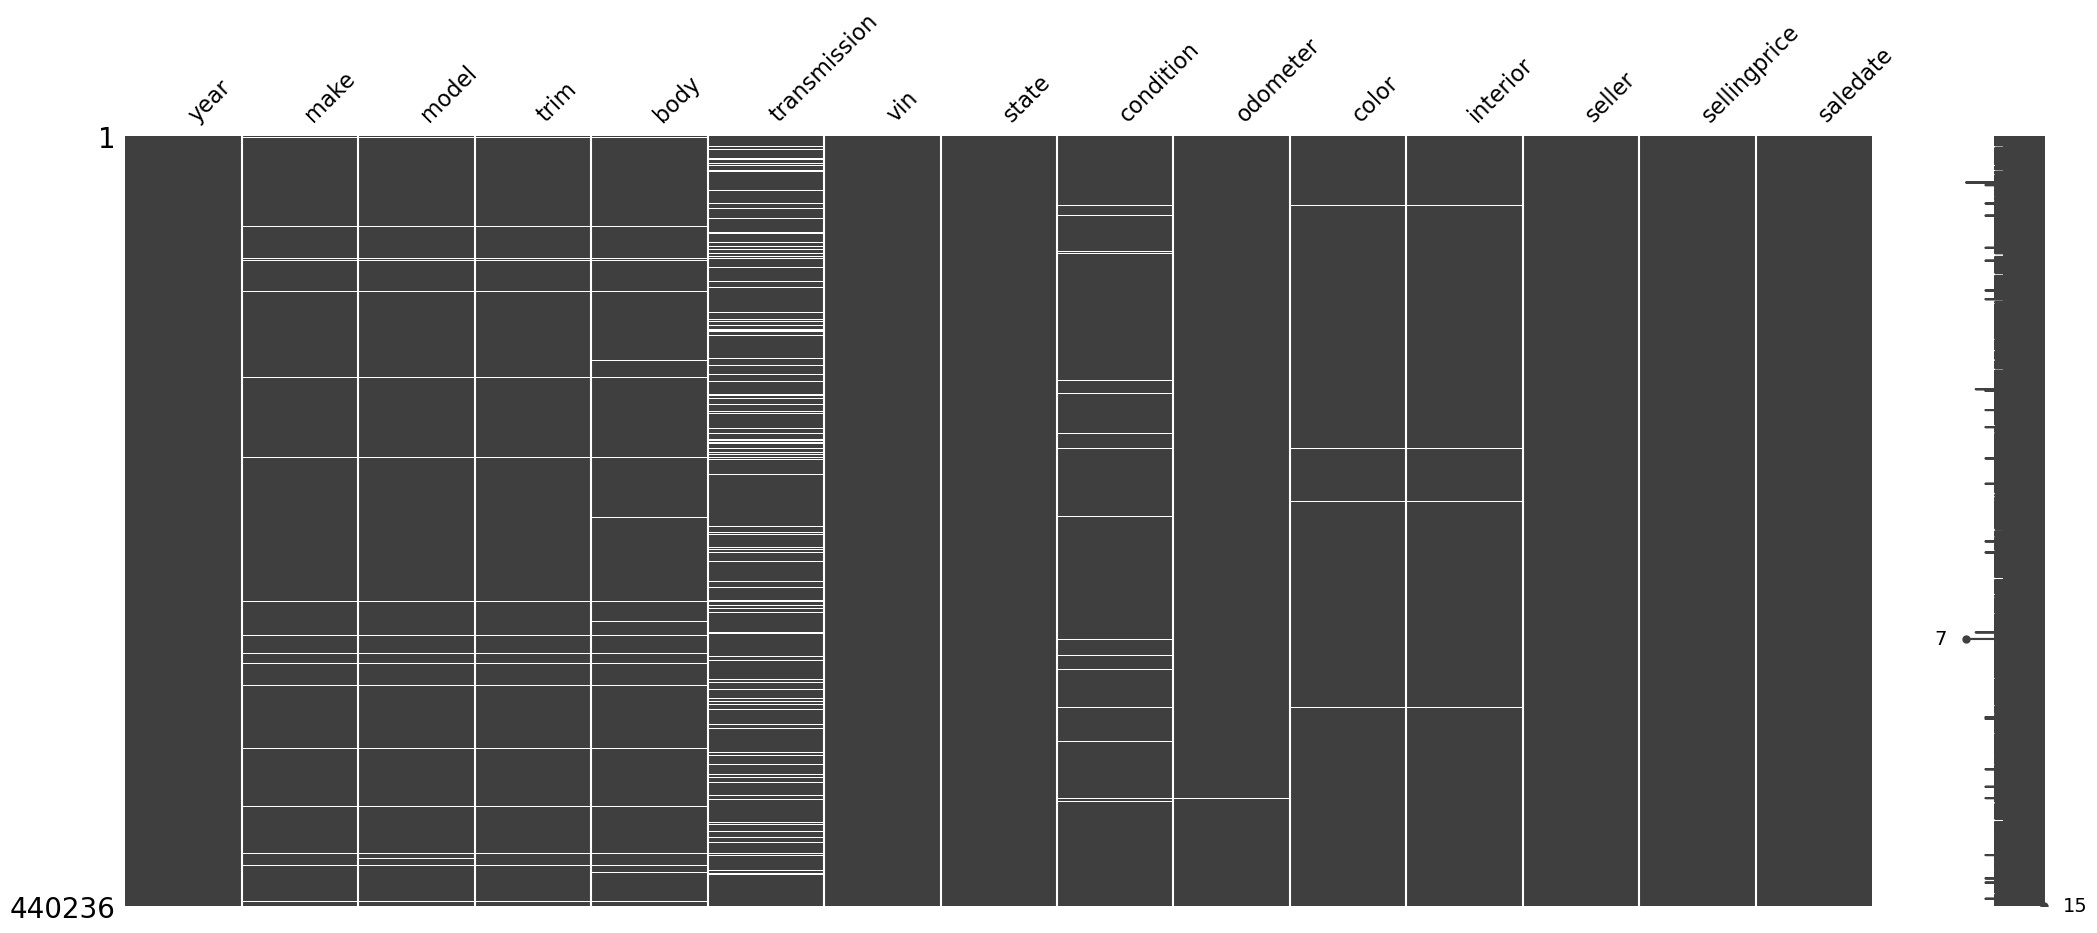

<Figure size 1500x900 with 0 Axes>

In [5]:
first_meeting(df_train)


Первые несколько строк:
   year       make         model      trim      body transmission  \
0  2005   Cadillac           CTS      Base     Sedan    automatic   
1  2014        GMC  Savana Cargo      2500       Van          NaN   
2  2013     Nissan        Murano         S       SUV    automatic   
3  2013  Chevrolet        Impala  LS Fleet     Sedan    automatic   
4  2013     Nissan         Titan        SV  Crew Cab    automatic   

                 vin state  condition  odometer   color interior  \
0  1g6dp567450124779    ca        2.7  116970.0  silver    black   
1  1gtw7fca7e1902207    pa        4.4    6286.0   white     gray   
2  jn8az1mw6dw303497    oh        4.6   11831.0    gray    black   
3  2g1wf5e34d1160703    fl        2.3   57105.0  silver    black   
4  1n6aa0ec3dn301209    tn        2.9   31083.0   black    black   

                                             seller  \
0                            lexus of stevens creek   
1                                        

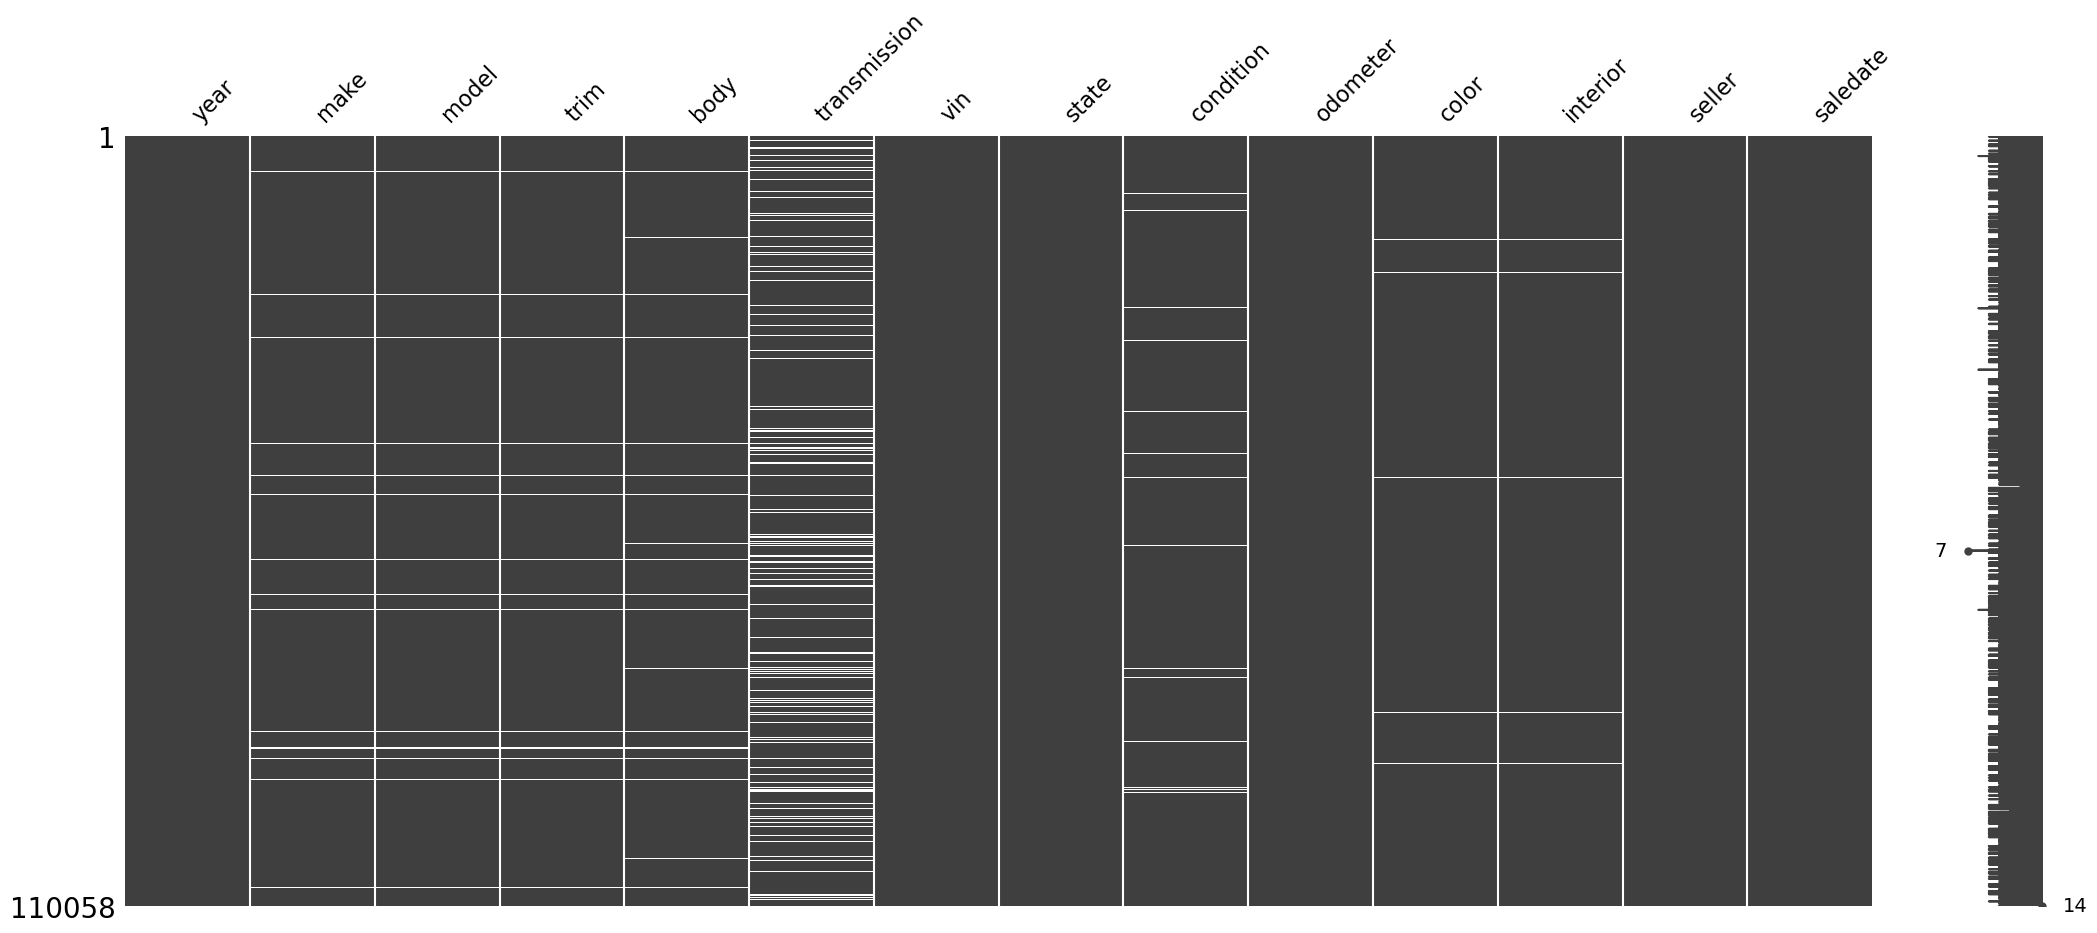

<Figure size 1500x900 with 0 Axes>

In [6]:
first_meeting(df_test)


Первые несколько строк:
                 vin  sellingprice
0  1g6dp567450124779  13592.209588
1  1gtw7fca7e1902207  13592.209588
2  jn8az1mw6dw303497  13592.209588
3  2g1wf5e34d1160703  13592.209588
4  1n6aa0ec3dn301209  13592.209588
---------------------------------
Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           110058 non-null  object 
 1   sellingprice  110058 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB
---------------------------------

Сводная статистика:
       sellingprice
count  1.100580e+05
mean   1.359221e+04
std    9.749827e-09
min    1.359221e+04
25%    1.359221e+04
50%    1.359221e+04
75%    1.359221e+04
max    1.359221e+04
---------------------------------

Размерность датасета:
(110058, 2)
---------------------------------


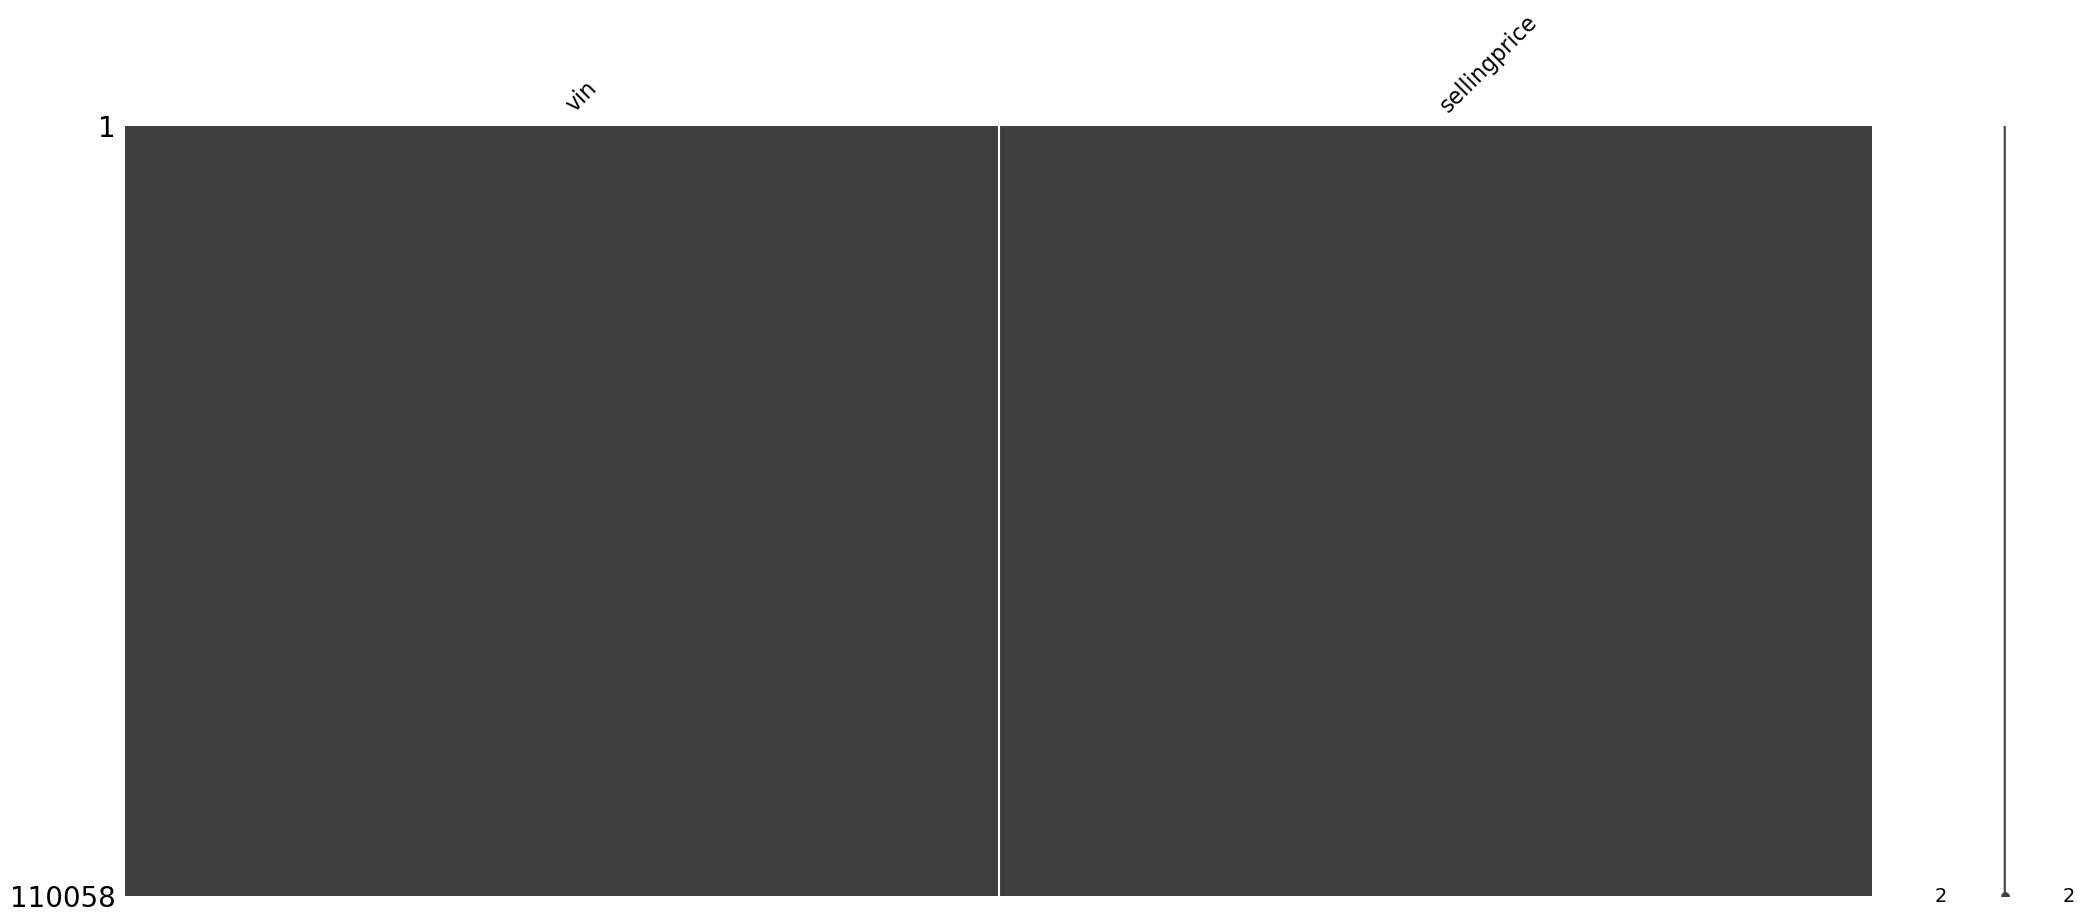

<Figure size 1500x900 with 0 Axes>

In [7]:
first_meeting(sub)

**в пропусках есть 3 интересных момента**

1) много пропусков одновременно находятся в этих признаках make, model, trim, body.
- на первый взгляд эти строки придется удалить т.к. информация содержится очень важная, а как ее восстанавливать я пока ума не приложу

2) так же много находятся отдельно в этих color, interior
-  тут скорее всего подойдет замена на black black - полагаю это будет самым популярным цветом

3) больше всего пропусков в body transmission
- ну и тут проведем небольшое исследование и скорее всего заменим на автомат для новых и дорогих машин и на механику для старых и дешевых

----------------
Минимальный возраст скорее всего поднимем до 2000+ года, а остальные объекты удалим. Цель исследования помочь пользователю не разбираясь в рынке машин - оценить собственный автомобиль, а старые машины не подчиняются текущим критериям оценки автомобиля 


Пример: toyota supra средняя стоимость в -

2000: 100000$

2014: 10000$

2023: 60000$


Есть вероятность того что алгоритм не правильно присвоит веса фиче - возраст автомобиля, да и предсказывать цены на такие авто слишком сложно т.к. на стоимость влияет уже непосредственно состояние автомобиля.

In [8]:
cat_cols = df_train.select_dtypes(include='object').columns.tolist()

In [9]:
df_train[cat_cols] = df_train[cat_cols].apply(lambda x: x.str.lower())
df_test[cat_cols] = df_test[cat_cols].apply(lambda x: x.str.lower())

- чуть чуть поработаем с датой и вернемся в пропускам

## feature engine

In [10]:
def to_datetime(df):
    pattern = r"(\w{3}) (\d{2}) (\d{4})"
    matches = re.search(pattern, df)
    new_string = " ".join([matches.group(1), matches.group(2), matches.group(3)])
    df = datetime.datetime.strptime(new_string, "%b %d %Y")
    return df

In [11]:
df_train['saledate'] = df_train['saledate'].apply(to_datetime)
df_test['saledate'] = df_test['saledate'].apply(to_datetime)

In [12]:
df_train['saledate'].dt.year.unique()

array([2015, 2014])

In [13]:
df_train['saledate'].dt.month.unique()

array([ 6,  2,  5,  1, 12,  3,  4,  7])

In [14]:
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-02
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-25
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-10
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-17
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-03


In [15]:
#df_train['km_per_year'] = df_train.apply(lambda row: row['odometer'] if row['saledate']
#                                         .year == row['year'] else row['odometer'] / (row['saledate']
#                                                                                      .year - row['year']), axis=1)
#df_test['km_per_year'] = df_test.apply(lambda row: row['odometer'] if row['saledate']
#                                         .year == row['year'] else row['odometer'] / (row['saledate']
#                                                                                      .year - row['year']), axis=1)

In [16]:
#df_train['age'] = df_train['saledate'].dt.year - df_train['year']
#df_test['age'] = df_test['saledate'].dt.year - df_test['year']


In [17]:
#df_train['model_median'] = df_train.groupby(['make','model'])['sellingprice'].transform('median')
#df_train['model_mean'] = df_train.groupby(['make','model'])['sellingprice'].transform('mean')

In [18]:
#df_train['color_same'] = df_train.apply(lambda row: 1 if row['interior'] == row['color'] else 0, axis=1)
#df_test['color_same'] = df_test.apply(lambda row: 1 if row['interior'] == row['color'] else 0, axis=1)

In [19]:
df_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-14
1,2014,gmc,savana cargo,2500,van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-27
2,2013,nissan,murano,s,suv,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-24
3,2013,chevrolet,impala,ls fleet,sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-06
4,2013,nissan,titan,sv,crew cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-03


In [20]:
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-02
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-25
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-10
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-17
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-03


**Объявления от 14 15 года**

In [21]:
df_train['season'] = df_train['saledate'].apply(lambda x: 'winter' if x.month in [12, 1, 2]
                                          else 'spring' if x.month in [3, 4, 5]
                                          else 'summer' if x.month in [6, 7, 8]
                                          else 'autumn' if x.month in [9, 10, 11]
                                          else '')

df_test['season'] = df_test['saledate'].apply(lambda x: 'winter' if x.month in [12, 1, 2]
                                          else 'spring' if x.month in [3, 4, 5]
                                          else 'summer' if x.month in [6, 7, 8]
                                          else 'autumn' if x.month in [9, 10, 11]
                                          else '')

In [22]:
df_train['saledate'].dt.month.unique()

array([ 6,  2,  5,  1, 12,  3,  4,  7])

In [23]:
df_train['season'].unique()

array(['summer', 'winter', 'spring'], dtype=object)

In [24]:
df_train = df_train.drop('saledate', axis = 1)
df_test = df_test.drop('saledate', axis = 1)

Осенью машины не продаем (: 

либо данные датасета с зимы 2014 до лета 2015

### пропуски make, model, trim, body

In [25]:
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,season
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,summer
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,winter
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,summer
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,summer
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,winter


In [26]:
cols_to_check = ['make', 'model', 'trim', 'body']

In [27]:
df_train.dropna(subset=cols_to_check, how='all',inplace = True)

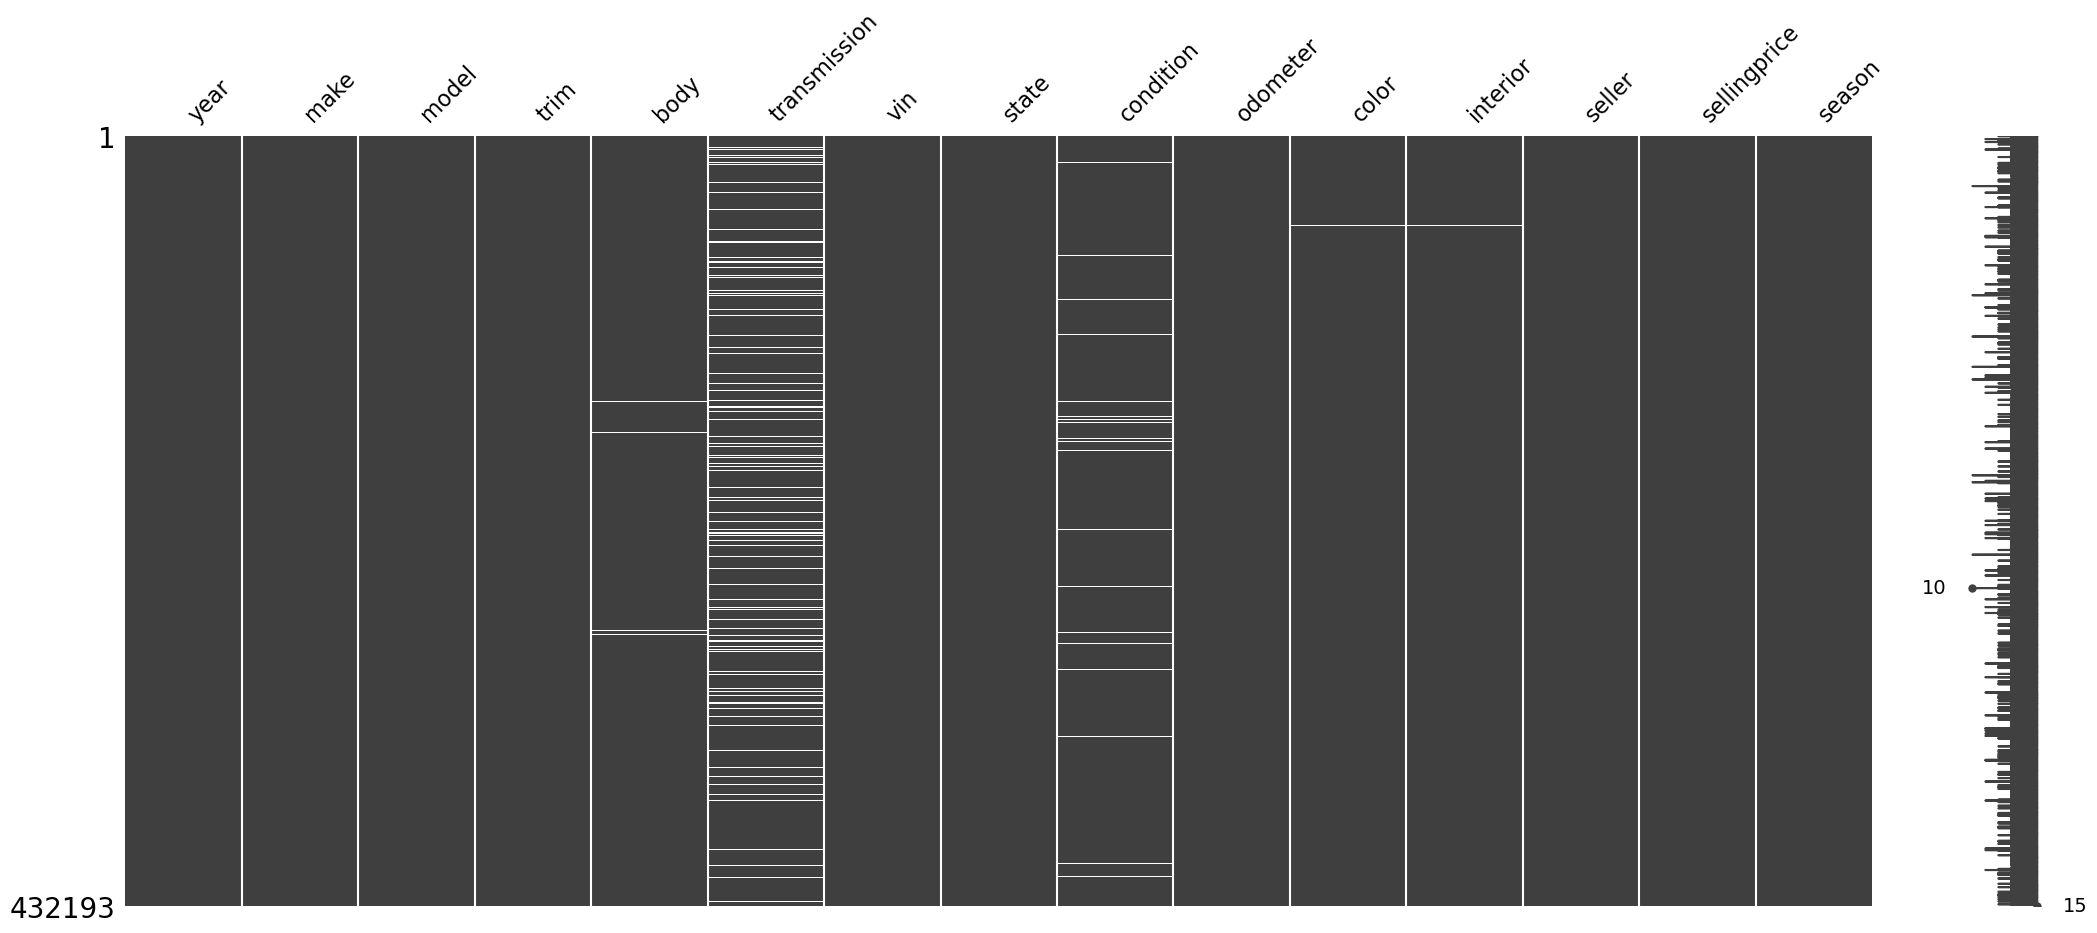

<Figure size 1500x900 with 0 Axes>

In [28]:
msno.matrix(df_train)
plt.figure(figsize = (15,9))
plt.show()

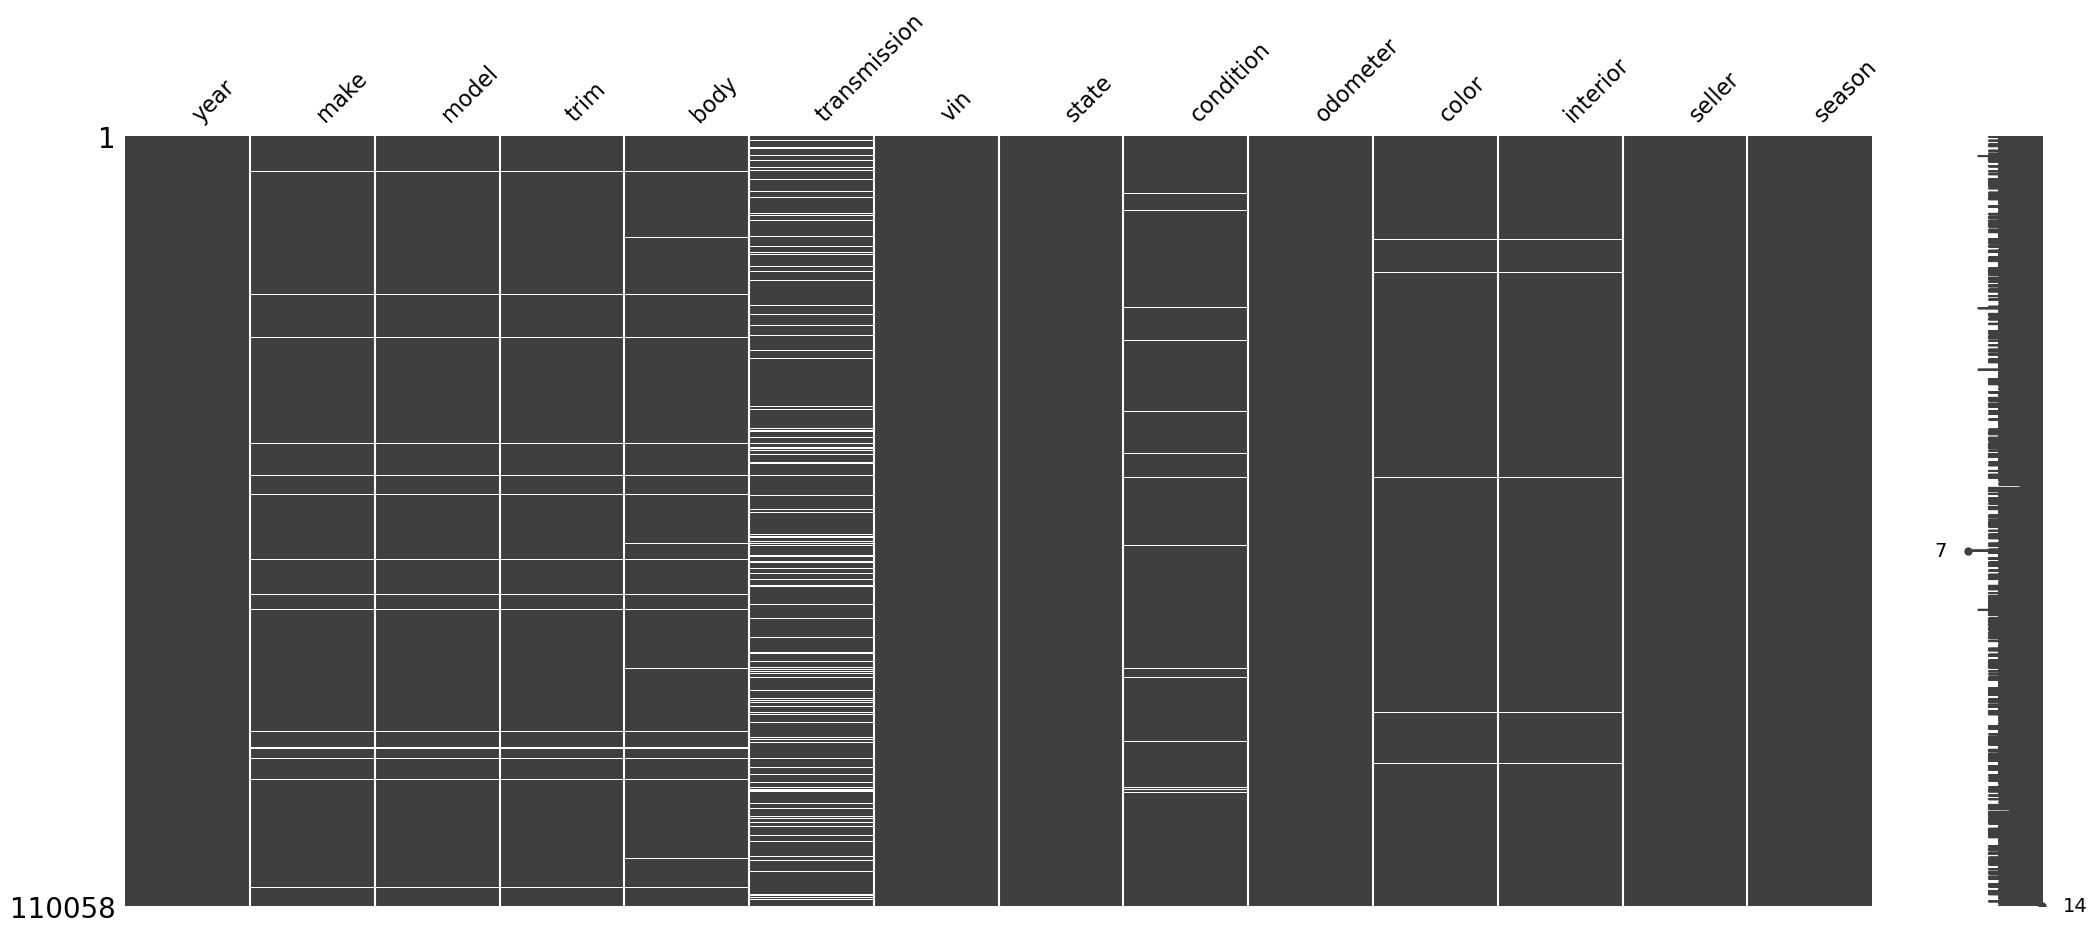

<Figure size 1500x900 with 0 Axes>

In [29]:
msno.matrix(df_test)
plt.figure(figsize = (15,9))
plt.show()

проблема с color, interior опала)

### пропуски body

In [30]:
df_train['body'].isna().sum()

2350

In [31]:
df_train['body'] = (df_train
                    .groupby('model')['body']
                    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "sedan")))

In [32]:
df_train['body'].isna().sum()

80

йеееее

In [33]:
df_train[df_train['body'].isna()]['trim'].unique()

array(['750li', '750li xdrive', '650i xdrive', '2.0 tfsi premium quattro',
       '750i xdrive', '750i'], dtype=object)

все модели седаны бмв и ауди это я знаю

In [34]:
df_train['body'] = df_train['body'].fillna('sedan')
df_train['body'].isna().sum()

0

In [35]:
df_test['body'].isna().sum()

2594

In [36]:
df_test['body'] = (df_test
                   .groupby('model')['body']
                   .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "sedan")))

In [37]:
df_test['body'].isna().sum()

2079

In [38]:
df_test[df_test['body'].isna()]['trim'].unique()

array([nan, '750li xdrive', '650i xdrive', '750li',
       '2.0 tfsi premium quattro', '750i xdrive'], dtype=object)

In [39]:
df_test['body'] = df_test['body'].fillna('sedan')

### пропуски condition

In [40]:
df_train['condition'].isna().sum()

9339

In [41]:
df_train[df_train['condition'].isna()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,season
89,1999,mercedes,e300dt,NaN,sedan,automatic,wdbjf25h9xa799907,mi,NaN,219516.0,green,beige,warren toyota,400,winter
122,2007,suzuki,reno,base,hatchback,automatic,kl5jd66z97k726834,il,NaN,127936.0,red,—,ray chevrolet inc,1800,winter
298,2006,chevrolet,silverado 1500,lt3,crew cab,automatic,2gcek13t761205016,ne,NaN,231208.0,burgundy,gray,woodhouse ford inc,6000,winter
303,2013,kia,sorento,lx,suv,automatic,5xyktda60dg359259,il,NaN,31404.0,burgundy,—,world hyundai matteson,16500,winter
326,2005,jeep,liberty,sport,suv,automatic,1j8gl48k25w621160,pa,NaN,102341.0,black,—,adcock brothers inc,4200,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439900,2001,infiniti,i30,base,sedan,automatic,jnkca31a81t019350,az,NaN,194302.0,brown,brown,right honda,1300,winter
439920,2013,chevrolet,silverado 1500,lt,extended cab,automatic,1gcrcse01dz410293,az,NaN,19431.0,black,black,yates buick gmc inc,22800,winter
440145,2010,mazda,mazda3,s grand touring,hatchback,automatic,jm1bl1h63a1137542,nj,NaN,104692.0,gray,—,d & d auto group llc,6650,winter
440166,2005,nissan,maxima,3.5 sl,sedan,automatic,1n4ba41e45c809875,fl,NaN,152938.0,gray,gray,gettel nissan of sarasota,2800,winter


заполним пропуски по столбцу trim т.к. там характеристика наиболее близкая к необходимой нам

In [42]:
df_train['condition'] = (df_train
                         .groupby('trim')['condition']
                         .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty
                                                       else df_train['condition'].median())))

In [43]:
df_train['condition'].isna().sum()

294

In [44]:
df_train[df_train['condition'].isna()]['trim'].unique()

array([nan], dtype=object)

все остальные пропуски для обоих столбцов, характеристика объема двигателя и комплектации довольно сильно влияют на цену современных авто. Пропусков не так много так что просто удалим те которые остались

In [45]:
df_test['condition'].isna().sum()

2379

In [46]:
df_test['condition'] = (df_test
                        .groupby('trim')['condition']
                        .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode()
                                                      .empty else df_train['condition'].median())))

In [47]:
df_test['condition'].isna().sum()

2114

In [48]:
df_test[df_test['condition'].isna()]['trim'].unique()

array([nan], dtype=object)

### пропуски transmission

In [49]:
df_train['transmission'].isna().sum()

50075

In [50]:
transmission_by_year = df_train.groupby(['transmission', 'year']).size().reset_index(name='count')

print(transmission_by_year.sort_values(by = 'year', ascending = False).head(30))

   transmission  year  count
29    automatic  2015   6289
58       manual  2015    117
57       manual  2014   1071
28    automatic  2014  54555
56       manual  2013   1540
27    automatic  2013  67926
26    automatic  2012  67649
55       manual  2012   1663
54       manual  2011   1025
25    automatic  2011  31878
53       manual  2010    765
24    automatic  2010  17300
52       manual  2009    635
23    automatic  2009  13703
22    automatic  2008  20866
51       manual  2008   1025
21    automatic  2007  19932
50       manual  2007    960
49       manual  2006    833
20    automatic  2006  17279
19    automatic  2005  13730
48       manual  2005    733
47       manual  2004    705
18    automatic  2004  10874
17    automatic  2003   8336
46       manual  2003    579
45       manual  2002    456
16    automatic  2002   6226
15    automatic  2001   4106
44       manual  2001    362


In [51]:
df_train[df_train['transmission'].isna()]['model'].nunique()

660

In [52]:
df_train['transmission'] = (df_train
                         .groupby('model')['transmission']
                         .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "automatic")))

In [53]:
df_train['transmission'].isna().sum()

80

In [54]:
df_test['transmission'].isna().sum()

13011

In [55]:
df_test['transmission'] = (df_test
                         .groupby('model')['transmission']
                         .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "automatic")))

In [56]:
df_test['transmission'].isna().sum()

2079

### пропуски color interior

In [57]:
df_train[['color', 'interior']].isna().sum()

color       572
interior    572
dtype: int64

In [58]:
df_train[['color', 'interior']] = df_train[['color', 'interior']].fillna('black')

In [59]:
df_test[['color', 'interior']].isna().sum()

color       158
interior    158
dtype: int64

In [60]:
df_test[['color', 'interior']] = df_test[['color', 'interior']].fillna('black')

### dropna

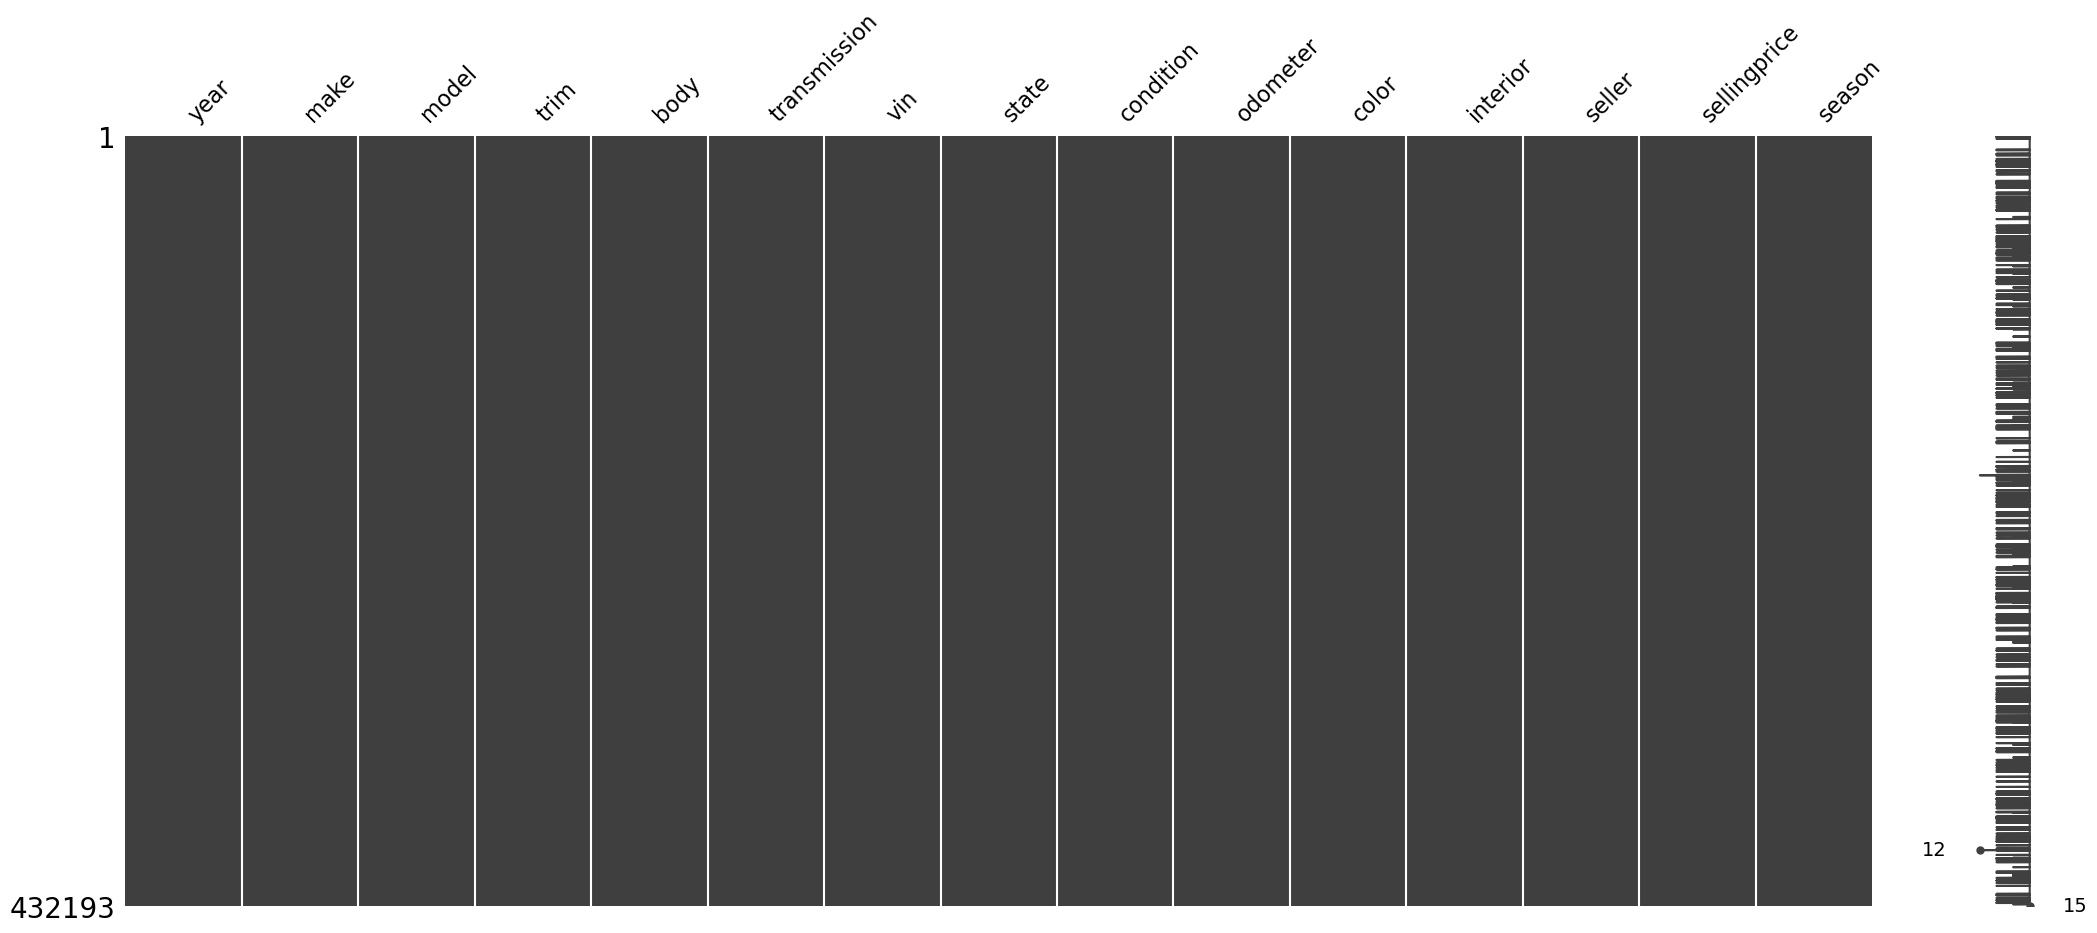

<Figure size 1500x900 with 0 Axes>

In [61]:
msno.matrix(df_train)
plt.figure(figsize = (15,9))
plt.show()

In [62]:
df_train = df_train.dropna()

In [63]:
len(df_train) / len(df_train_first)

0.9807330613579989

In [64]:
cat_cols = df_test.select_dtypes(include='object').columns.tolist()
for column in cat_cols:
    df_test[column].fillna(df_test[column].mode()[0], inplace=True)
numeric_columns = ['condition','odometer']
for column in numeric_columns:
    df_test[column].fillna(df_test[column].median(), inplace=True)


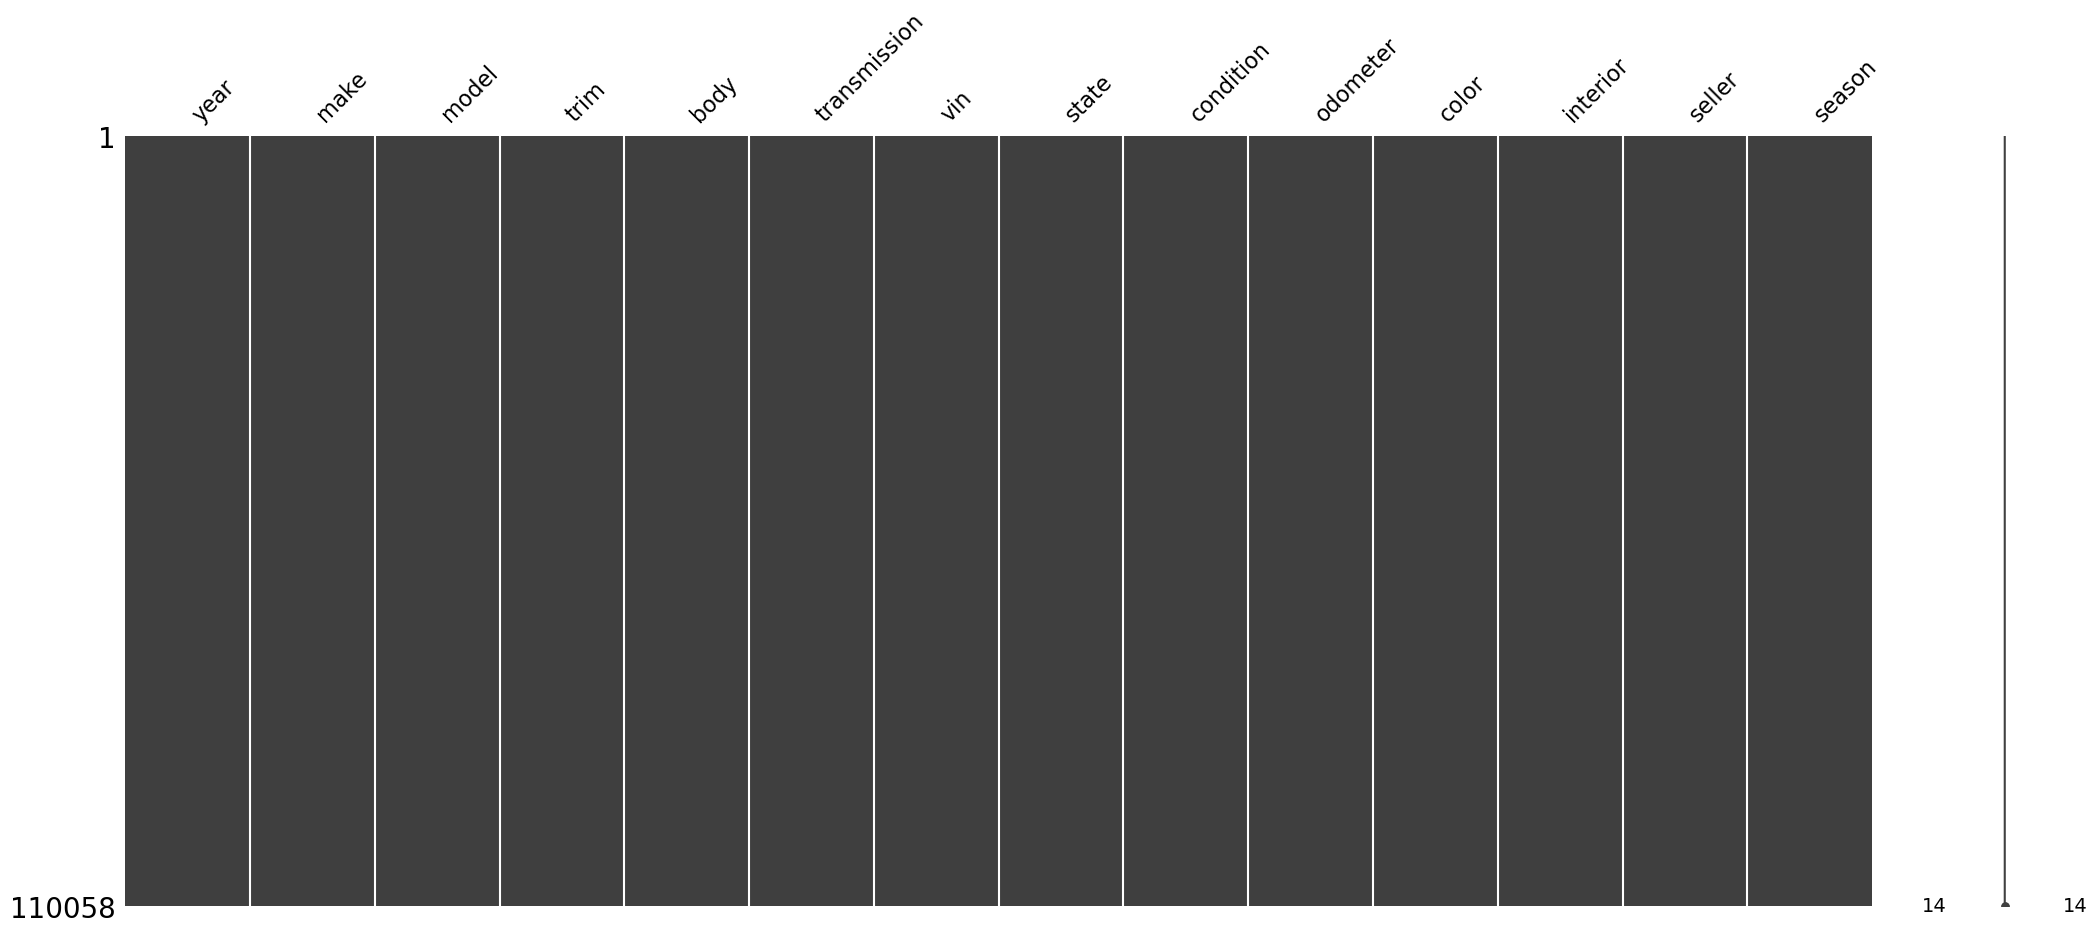

<Figure size 1500x900 with 0 Axes>

In [65]:
msno.matrix(df_test)
plt.figure(figsize = (15,9))
plt.show()

In [66]:
df_test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
season          0
dtype: int64

In [67]:
len(df_test)/len(df_test_first)

1.0

2% данных нам пришлось удалить, почти все 2% это данные в которых пропущены значения во всех 4 столбцах (make, model, trim, body) сразу

In [68]:
df_train.duplicated().sum()

0

In [69]:
df_test.duplicated().sum()

0

In [70]:
df_train['vin'].duplicated().sum()

0

In [71]:
df_test['vin'].duplicated().sum()

0

Полных дубликатов нет. Дубликатов там где их быть не должно тоже нет.

Создадим фичу продается ли машина у оффициального дилера

In [72]:
#def is_official_dealer(row):
#    if row['make'] in row['seller']:
#        return 1
#    else:
#        return 0

In [73]:
#df_train['seller'] = df_train.apply(is_official_dealer, axis=1)

In [74]:
#df_test['seller'] = df_test.apply(is_official_dealer, axis=1)

In [75]:
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,season
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,summer
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,winter
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,summer
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,summer
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,winter


## preprocessing result

1) Все наблюдения в датасете были переведены в нижний регистр.



2) Проведена работа с пропусками. Удалены пропуски в столбцах где значения пропущены в  makе, model,trim,body одновременно, у меня нет идей как восстановить такую дыру, а затычки по моему мнению ухудшат результат. Тем не менее нам удалось сохранить 97 процентов всех данных.



3) Остальные пропуски заполнены по совпадениям.



4) Созданы два признака 
- время года когда была выставленна машина. 

- продается ли машина у офф. дилера.
5) дубликатов нет

# EDA

In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431754 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          431754 non-null  int64  
 1   make          431754 non-null  object 
 2   model         431754 non-null  object 
 3   trim          431754 non-null  object 
 4   body          431754 non-null  object 
 5   transmission  431754 non-null  object 
 6   vin           431754 non-null  object 
 7   state         431754 non-null  object 
 8   condition     431754 non-null  float64
 9   odometer      431754 non-null  float64
 10  color         431754 non-null  object 
 11  interior      431754 non-null  object 
 12  seller        431754 non-null  object 
 13  sellingprice  431754 non-null  int64  
 14  season        431754 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 52.7+ MB


In [77]:
def uni_count(df):
    result = []
    for column in df.columns:
        uniq = df[column].nunique()
        v_counts = df[column].value_counts()
        result.append(("---------------", column, "---------------"))
        result.append((uniq, v_counts))
    return result

In [78]:
uni_count(df_train)

[('---------------', 'year', '---------------'),
 (27, 2012    79889
  2013    77521
  2014    63763
  2011    37849
  2008    24295
  2007    23013
  2010    20240
  2006    19947
  2009    15912
  2005    15877
  2004    12963
  2003    10128
  2002     7626
  2015     7280
  2001     5113
  2000     3598
  1999     2372
  1998     1561
  1997     1061
  1996      610
  1995      516
  1994      290
  1993      144
  1992       94
  1991       55
  1990       35
  1989        2
  Name: year, dtype: int64),
 ('---------------', 'make', '---------------'),
 (60,
  ford             74045
  chevrolet        47712
  nissan           42841
  toyota           31700
  dodge            24282
  honda            21592
  hyundai          17186
  bmw              16178
  kia              14323
  chrysler         13794
  mercedes-benz    13343
  infiniti         12122
  jeep             12105
  volkswagen        9880
  lexus             9363
  gmc               8355
  mazda             6654
  cadi

## уменьшаем кол-во уникальных значений

In [79]:
def to_other(df,column,num):
    
    vc = df[column].value_counts()
    
    less = vc[vc <= num].index.tolist()
    
    df.loc[df[column].isin(less), column] = 'other'

    return df

### make 

In [80]:
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,season
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,summer
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,winter
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,summer
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,summer
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,winter


In [81]:
def rename_position(row):
    if 'mercedes' in row:
        return 'mercedes-benz'
    else:
        return row

In [82]:
df_train['make'] = df_train['make'].apply(rename_position)
df_test['make'] = df_test['make'].apply(rename_position)

### model

In [83]:
#df_train = to_other(df_train,'model',50)
#df_test = to_other(df_test,'model',50)

### trim

In [84]:
#df_train = to_other(df_train,'trim',100)
#df_test = to_other(df_test,'trim',100)

### body

In [85]:
#df_train = to_other(df_train,'trim',10)
#df_test = to_other(df_test,'trim',10)

### odometer

In [86]:
#df_train['odometer'] = pd.qcut(df_train['odometer'], q=5)
#df_test['odometer'] = pd.qcut(df_test['odometer'], q=5)

## visual

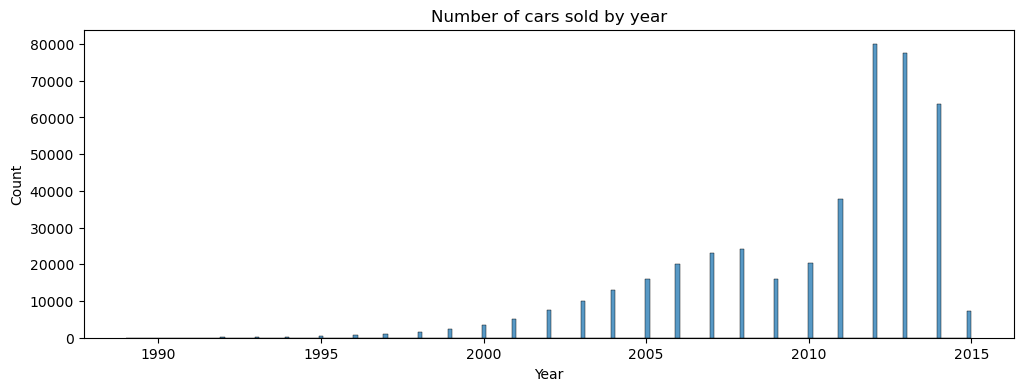

In [87]:
plt.figure(figsize=(12, 4))
sns.histplot(x=df_train['year'])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of cars sold by year")
plt.show()

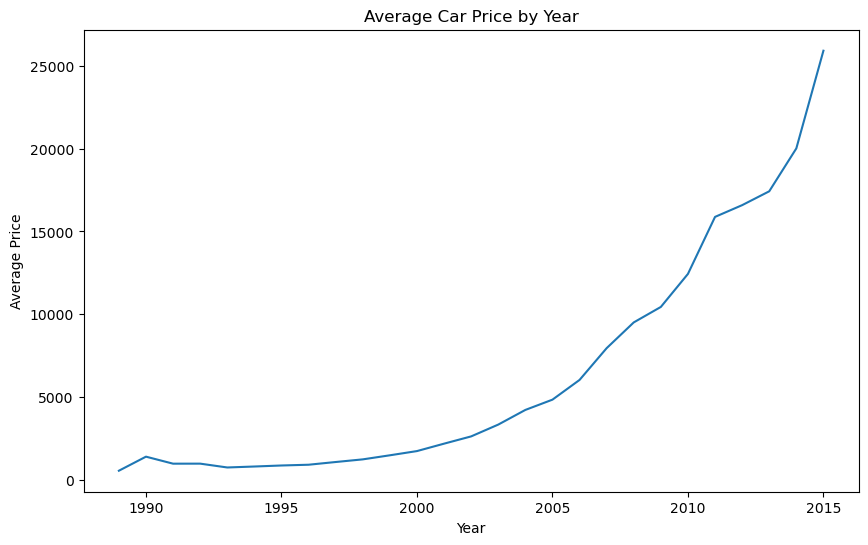

In [88]:
mean_prices = df_train.groupby('year')['sellingprice'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_prices.index, y=mean_prices.values)
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title("Average Car Price by Year")
plt.show()

**биткоин :D**

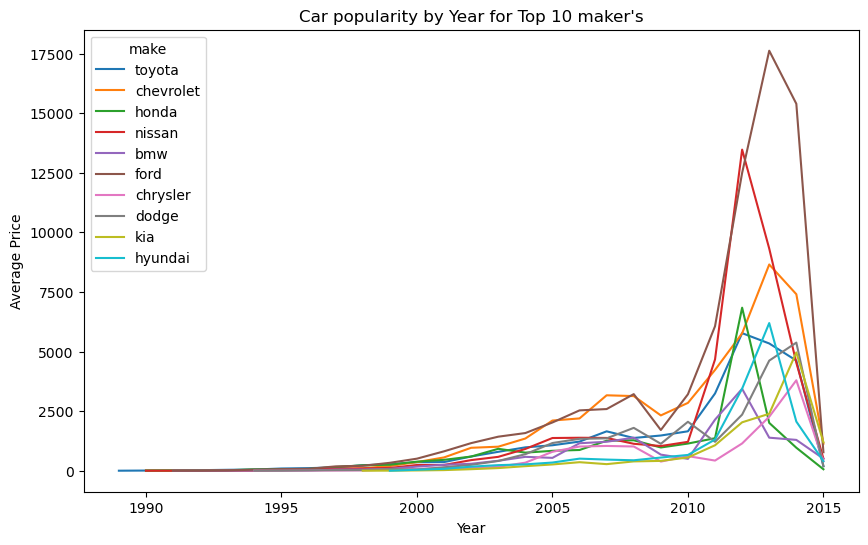

In [89]:
popularity = df_train.groupby(['year', 'make']).size().reset_index(name='Count')

top_10_manufacturers = popularity.groupby('make')['Count'].sum().nlargest(10).index

filtered_data = popularity[popularity['make'].isin(top_10_manufacturers)]

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='Count', hue='make', data=filtered_data)
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title("Car popularity by Year for Top 10 maker's")
plt.legend(title='make')
plt.show()

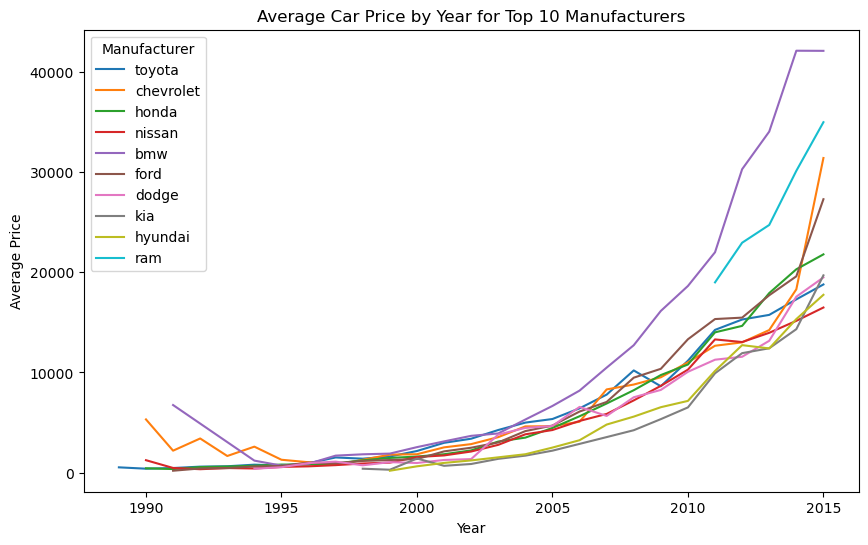

In [90]:
mean_prices = df_train.groupby(['year', 'make'])['sellingprice'].agg(['count','mean']).reset_index()

top_10_manufacturers = mean_prices.groupby('make')['count'].mean().nlargest(10).index

filtered_data = mean_prices[mean_prices['make'].isin(top_10_manufacturers)]

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='mean', hue='make', data=filtered_data)
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title("Average Car Price by Year for Top 10 Manufacturers")
plt.legend(title='Manufacturer')
plt.show()


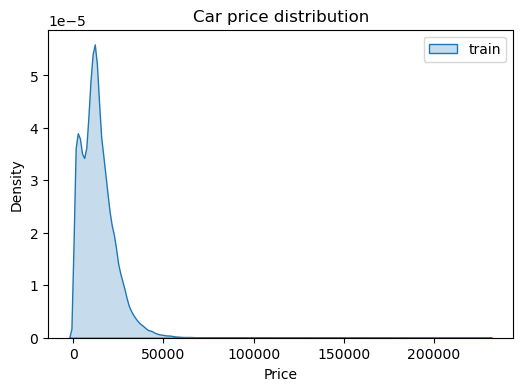

In [91]:
fig, ax_kde = plt.subplots(figsize=(6,4))

sns.kdeplot(df_train['sellingprice'], label='train', fill=True)
ax_kde.set(xlabel='Price',
           ylabel='Density',
           title = 'Car price distribution')
plt.legend();

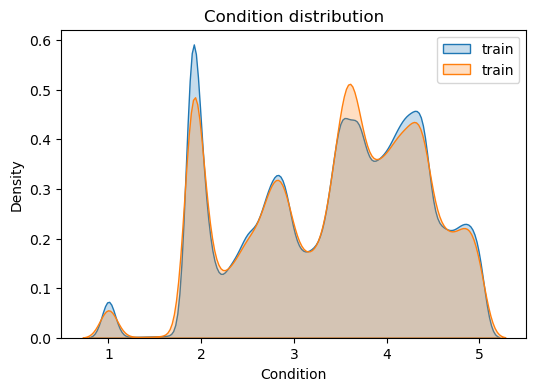

In [92]:
fig, ax_kde = plt.subplots(figsize=(6,4))

sns.kdeplot(df_train['condition'], label='train', fill=True)
sns.kdeplot(df_test['condition'], label='train', fill=True)
ax_kde.set(xlabel='Condition',
           ylabel='Density',
           title = 'Condition distribution')
plt.legend();

# ML

## encoder

In [93]:
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,season
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,summer
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,winter
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,summer
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,summer
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,winter


In [94]:
df_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,season
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,winter
1,2014,gmc,savana cargo,2500,van,automatic,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,winter
2,2013,nissan,murano,s,suv,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,winter
3,2013,chevrolet,impala,ls fleet,sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,spring
4,2013,nissan,titan,sv,crew cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,summer


In [95]:
X_train = df_train.drop(['vin','sellingprice'],axis=1)
X_test = df_test.drop('vin',axis=1)
y_train = df_train['sellingprice']

In [96]:
ohe_names = ['transmission','season']
target_names = ['make','model','trim','body','seller','state','color','interior','odometer']

In [97]:
def encode_data(X_train, X_test, ohe_names, target_names):
    encoder_ohe = OneHotEncoder()
    X_train_ohe = encoder_ohe.fit_transform(X_train[ohe_names])
    X_test_ohe = encoder_ohe.transform(X_test[ohe_names])
    X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=encoder_ohe.get_feature_names_out(ohe_names))
    X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=encoder_ohe.get_feature_names_out(ohe_names))
    
    target = TargetEncoder()
    X_train_me = target.fit_transform(X_train[target_names], y_train)
    X_test_me = target.transform(X_test[target_names])
    
    X_train_encoded = pd.concat([X_train.drop(columns=ohe_names+target_names), X_train_ohe_df, X_train_me], axis=1)
    X_test_encoded = pd.concat([X_test.drop(columns=ohe_names+target_names), X_test_ohe_df, X_test_me], axis=1)
    
    return X_train_encoded, X_test_encoded

In [98]:
X_train_encoded, X_test_encoded = encode_data(X_train, X_test, ohe_names, target_names)

<Axes: >

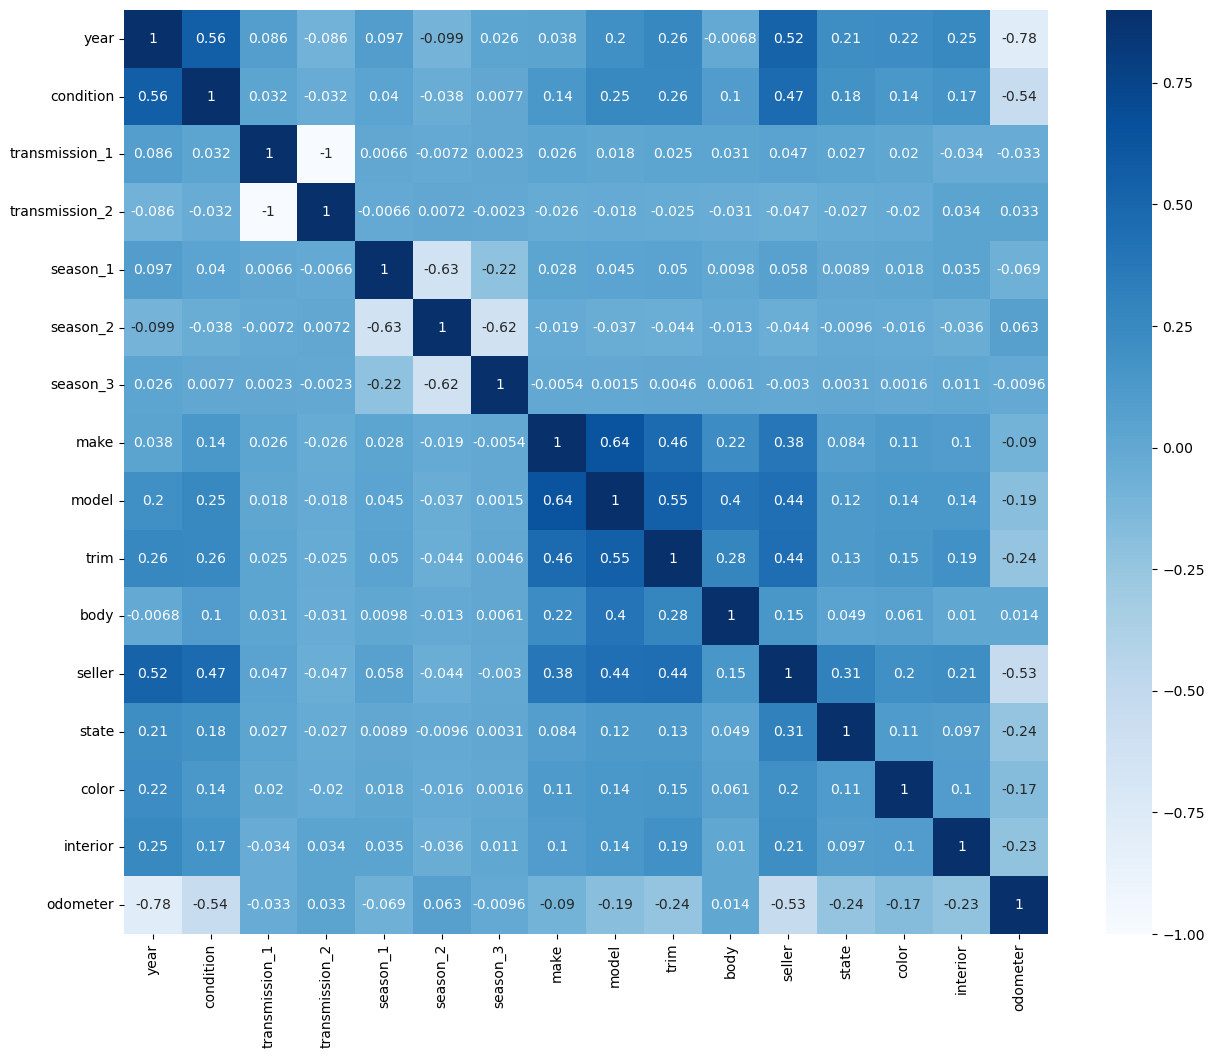

In [99]:
corr = X_train_encoded.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True,annot = True)

## DBSCAN feature

In [100]:
#X_combined = np.vstack((X_train_encoded, X_test_encoded))

In [101]:
#X_combined

In [102]:
#dbscan = DBSCAN(eps=0.5, min_samples=5)
#dbscan.fit(X_combined)

In [103]:
#test_cluster_labels = dbscan.labels_

In [104]:
#X_test_with_cluster_labels = np.column_stack((X_combined, test_cluster_labels))

In [105]:
#X_train_encoded = X_test_with_cluster_labels[:len(X_train_encoded)]
#X_test_encoded = X_test_with_cluster_labels[len(X_train_encoded):]

## Scale

In [106]:
scaler = StandardScaler()

In [107]:
X_train_scale = scaler.fit_transform(X_train_encoded)
X_test_scale = scaler.transform(X_test_encoded)

In [108]:
def mape(model,X, y):
    mape = cross_val_score(model, X, y, cv=5,scoring='neg_mean_absolute_percentage_error')
    return f'MAPE: {-mape.mean()}'

## Linear models

### LR

In [109]:
lr = LinearRegression()

In [110]:
mape(lr,X_train_scale,y_train)

'MAPE: 0.6291336157669244'

## ridge

In [111]:
ridge = Ridge()

In [112]:
mape(ridge,X_train_scale,y_train)

'MAPE: 0.6291019103057098'

## lasso

In [113]:
lasso = Lasso()

In [114]:
mape(lasso,X_train_scale,y_train)

'MAPE: 0.6289339753270815'

## elastic

In [115]:
elastic = ElasticNet()

In [116]:
mape(elastic,X_train_scale,y_train)

'MAPE: 0.5301514772906784'

## Poly

### lr + poly

In [117]:
poly = PolynomialFeatures(degree = 2)

In [118]:
#X_poly_train = poly.fit_transform(X_train_encoded)
#X_poly_test = poly.transform(X_test_encoded)

In [119]:
#mape(lr,X_poly_train,y_train)

## Boosting

### lgb

In [120]:
model_lgb = lgb.LGBMRegressor()

In [121]:
#mape(model_lgb,X_train_encoded,y_train)

In [122]:
#model_lgb.fit(X_poly_train,y_train)

In [123]:
#lgb_pred = model_lgb.predict(X_poly_test)

In [124]:
#lgb_pred

In [125]:
#sub['sellingprice'] = lgb_pred

In [126]:
#sub.to_csv('file.csv', index=False)

### XGboost

In [143]:
xgb_model = xgb.XGBRegressor(learning_rate = 0.25,
                             max_depth = 8, n_estimators = 750,
                             alpha = 0.3, min_child_weight = 3)

In [ ]:
mape(xgb_model,X_train_encoded,y_train)

xgb_model = xgb.XGBRegressor(learning_rate = 0.25, max_depth = 8, n_estimators = 750,  alpha = 0.3)

'MAPE: 0.141423976850808'

In [135]:
xgb_model.fit(X_train_encoded,y_train)

XGBRegressor(alpha=0.3, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=750, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [136]:
xgb_pred = xgb_model.predict(X_test_encoded)

In [137]:
sub['sellingprice'] = xgb_pred

In [138]:
sub.to_csv('file.csv', index=False)